# Домашнее задание №5. Дедлайн - 8 декабря
Основы машинного обучения. В.Журавлев  
Группа ML-13. __Студент - Усцов Артем Алексеевич__

- Участникам предоставлен набор данных объявлений о продаже недвижимости в некотором волшебном городе N.  
- __Задача__ - предсказать цену недвижимости по содержанию объявления

## Part 0. Service function declaration

Connecting all the libraries necessary for work and declaring functions

In [1]:
# Future Python versions compatibility
from __future__ import division

# Warnings Ignore
import warnings
warnings.filterwarnings("ignore")

# System libraries
import os

# Object libraries
import pandas as pd
import numpy as np
import seaborn as sns

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score, recall_score, roc_curve, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

# Data Transformers
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.compose import ColumnTransformer

# Visualize libraries
import matplotlib.pyplot as plt
import matplotlib.colors as colors
# Colors map
colors_list = list(colors._colors_full_map.values())
%matplotlib inline

# Time libraries
from tqdm import tqdm_notebook
import time

In [2]:
# Missing values detection function
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
                                mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
                                '% of Total Values', ascending=False).round(2)

    print("Your selected dataframe has "  + str(df.shape[0]) + " objects with " + str(df.shape[1]) 
                                          + " features.\n"
                             "There are " + str(mis_val_table_ren_columns.shape[0]) +
                             " features that have missing values.")

    return mis_val_table_ren_columns

## Part 1. Data Processing

Let's have a look for data structure, types and distribution

In [3]:
# Current path
print("Current path is: ", os.getcwd())
# Data path
os.chdir(os.path.join(os.getcwd(), 'data'))
print("Data path is: ", os.getcwd())

Current path is:  /home/tater/Technopark/Sem_1/ML_Homeworks/HW_5
Data path is:  /home/tater/Technopark/Sem_1/ML_Homeworks/HW_5/data


In [63]:
# Data downloading
main_train_df = pd.read_csv("Train.csv")
main_test_df = pd.read_csv("Test.csv")

In [64]:
# Data overlook : main_train_df
main_train_df.head()

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
0,0,2011-1,30,0.0,10,48,2,0,30.0,NaN,...,0,0,0,0,0,0,0,0,0,4252000
1,1,2011-1,376,1.0,2,53,2,0,30.0,1.0,...,0,0,0,0,0,0,0,0,0,4463000
2,2,2011-1,549,NaN,8,61,3,1,30.0,0.0,...,0,0,0,0,0,0,0,0,0,4518000
3,3,2011-1,321,1.0,10,47,1,1,30.0,0.0,...,0,0,0,0,0,0,0,0,0,6785000
4,4,2011-1,636,NaN,3,58,3,0,25.0,NaN,...,0,0,0,0,0,0,0,0,0,1677000


In [65]:
main_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          100000 non-null  int64  
 1   date        100000 non-null  object 
 2   street_id   100000 non-null  int64  
 3   build_tech  70062 non-null   float64
 4   floor       100000 non-null  int64  
 5   area        100000 non-null  int64  
 6   rooms       100000 non-null  int64  
 7   balcon      100000 non-null  int64  
 8   metro_dist  95098 non-null   float64
 9   g_lift      69636 non-null   float64
 10  n_photos    100000 non-null  int64  
 11  kw1         100000 non-null  int64  
 12  kw2         100000 non-null  int64  
 13  kw3         100000 non-null  int64  
 14  kw4         100000 non-null  int64  
 15  kw5         100000 non-null  int64  
 16  kw6         100000 non-null  int64  
 17  kw7         100000 non-null  int64  
 18  kw8         100000 non-null  int64  
 19  kw9

There are only integer or float numbers. Date is an object. Shoud it be transformed into datetime64?

In [66]:
main_train_df['date'] = pd.to_datetime(main_train_df['date'])

In [67]:
start = min(main_train_df.date)
main_train_df.date = main_train_df.date - start
main_train_df.date = main_train_df.date.convert_dtypes(float) / 24 / 60 / 60 / 10 ** 9  + 100 # дни (+100 нужно для корректного расчета весов для бустинга)
main_train_df.head()

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
0,0,100.0,30,0.0,10,48,2,0,30.0,NaN,...,0,0,0,0,0,0,0,0,0,4252000
1,1,100.0,376,1.0,2,53,2,0,30.0,1.0,...,0,0,0,0,0,0,0,0,0,4463000
2,2,100.0,549,NaN,8,61,3,1,30.0,0.0,...,0,0,0,0,0,0,0,0,0,4518000
3,3,100.0,321,1.0,10,47,1,1,30.0,0.0,...,0,0,0,0,0,0,0,0,0,6785000
4,4,100.0,636,NaN,3,58,3,0,25.0,NaN,...,0,0,0,0,0,0,0,0,0,1677000


In [68]:
main_train_df.head().T

,0,1,2,3,4
id,0.0,1.0,2.0,3.0,4.0
date,100.0,100.0,100.0,100.0,100.0
street_id,30.0,376.0,549.0,321.0,636.0
build_tech,0.0,1.0,NaN,1.0,NaN
floor,10.0,2.0,8.0,10.0,3.0
area,48.0,53.0,61.0,47.0,58.0
rooms,2.0,2.0,3.0,1.0,3.0
balcon,0.0,0.0,1.0,1.0,0.0
metro_dist,30.0,30.0,30.0,30.0,25.0
g_lift,NaN,1.0,0.0,0.0,NaN


Apparently, the signs of kw1-kw13 are very rarefied. Let's have a look

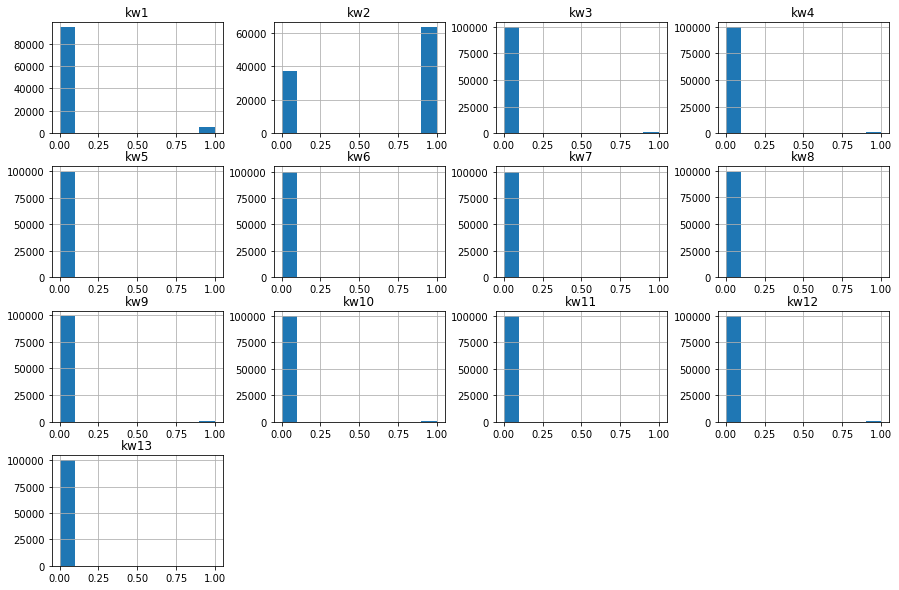

In [69]:
main_train_df.iloc[:, 11:24].hist(figsize=(15, 10))
plt.show()

Yes, our hypothesis __was confirmed.__
Briefly it looks like a binary feature. So leave only the kw-1 and kw-2 features in the dataset

In [70]:
main_train_df.drop(main_train_df.columns[13:24], axis=1, inplace=True)
main_train_df.describe()

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw1,kw2,price
count,100000.000000,100000.000000,100000.000000,70062.000000,100000.000000,100000.000000,100000.000000,100000.000000,95098.000000,69636.000000,100000.000000,100000.000000,100000.000000,1.000000e+05
mean,49999.500000,387.195420,335.941620,0.531429,5.331930,52.477830,2.120300,0.399500,21.796883,0.499540,2.499250,0.056910,0.630200,5.178324e+06
std,28867.657797,208.563293,193.695516,0.577679,4.010817,17.927695,0.827874,0.551292,8.317160,0.500003,1.959571,0.231672,0.482753,4.402954e+06
min,0.000000,100.000000,0.000000,0.000000,1.000000,29.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.570000e+05
25%,24999.750000,220.000000,169.000000,0.000000,2.000000,41.000000,1.000000,0.000000,15.000000,0.000000,1.000000,0.000000,0.000000,2.589000e+06
50%,49999.500000,343.000000,336.000000,0.000000,4.000000,52.000000,2.000000,0.000000,25.000000,0.000000,2.000000,0.000000,1.000000,4.086000e+06
75%,74999.250000,496.000000,503.000000,1.000000,7.000000,60.000000,3.000000,1.000000,30.000000,1.000000,4.000000,0.000000,1.000000,6.285000e+06
max,99999.000000,800.000000,671.000000,2.000000,25.000000,217.000000,6.000000,2.000000,30.000000,1.000000,11.000000,1.000000,1.000000,8.331500e+07


There is useless __"id"__ feature. Drop it from dataset

In [71]:
main_train_df.drop('id', axis=1, inplace=True)

In [72]:
main_train_df.isnull().any()

date          False
street_id     False
build_tech     True
floor         False
area          False
rooms         False
balcon        False
metro_dist     True
g_lift         True
n_photos      False
kw1           False
kw2           False
price         False
dtype: bool

There are empty cells with values. Need detailed data analysis or replacement of gaps with a value?

In [73]:
missing_values_table(main_train_df)

Your selected dataframe has 100000 objects with 13 features.
There are 3 features that have missing values.


,Missing Values,% of Total Values
g_lift,30364,30.36
build_tech,29938,29.94
metro_dist,4902,4.90


As we can see, the number of gaps in the first and second features is quite significant.   
The strategy of deleting characteristics will not work, __only the replacement of values is possible__

In [74]:
print(f"1) g_lift unique values: {pd.unique(main_train_df['g_lift'])}")
print(f"2) build_tech unique values: {pd.unique(main_train_df['build_tech'])}")
print(f"3) metro_dist unique values: {pd.unique(main_train_df['metro_dist'])}")

1) g_lift unique values: [nan  1.  0.]
2) build_tech unique values: [ 0.  1. nan  2.]
3) metro_dist unique values: [30. 25. 15. 20. 10. nan  5.  0.]


As we can see the "g_lift" is binary categorical data, "build_tech" is a triple categorical data
Also "metro_dist" is a multicategorical data.   
__Thus, the replacement by the median will be quoted only for the "metro_dist" feature__  


For the rest, we will interpret the omission as another "special" category.

In [75]:
# main_train_df[['g_lift', 'build_tech']] = main_train_df[['g_lift', 'build_tech']].fillna('NA', axis=0).applymap(str)
# main_train_df['metro_dist'].fillna(main_train_df.metro_dist.median(), inplace=True)

In [76]:
missing_values_table(main_train_df)

Your selected dataframe has 100000 objects with 13 features.
There are 3 features that have missing values.


,Missing Values,% of Total Values
g_lift,30364,30.36
build_tech,29938,29.94
metro_dist,4902,4.90


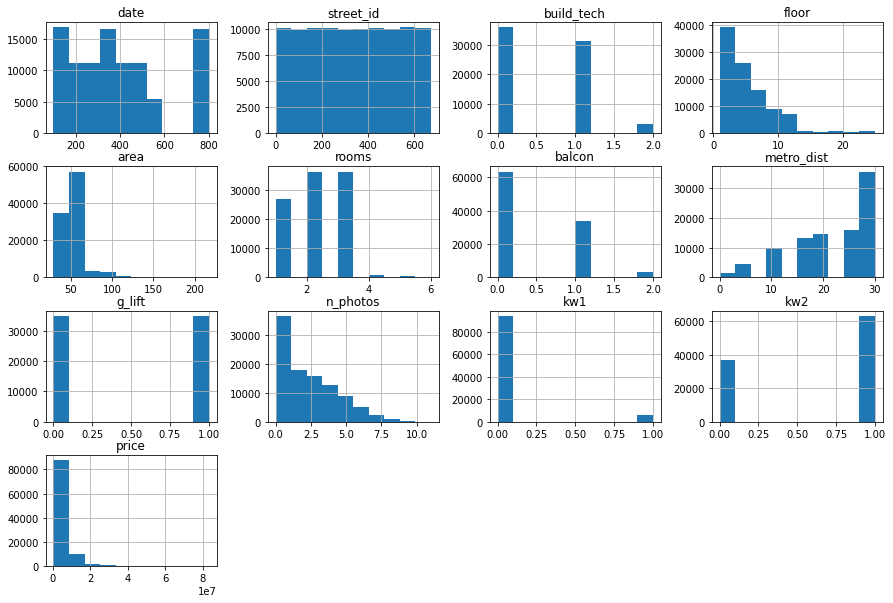

In [77]:
main_train_df.hist(figsize=(15, 10))
plt.show()

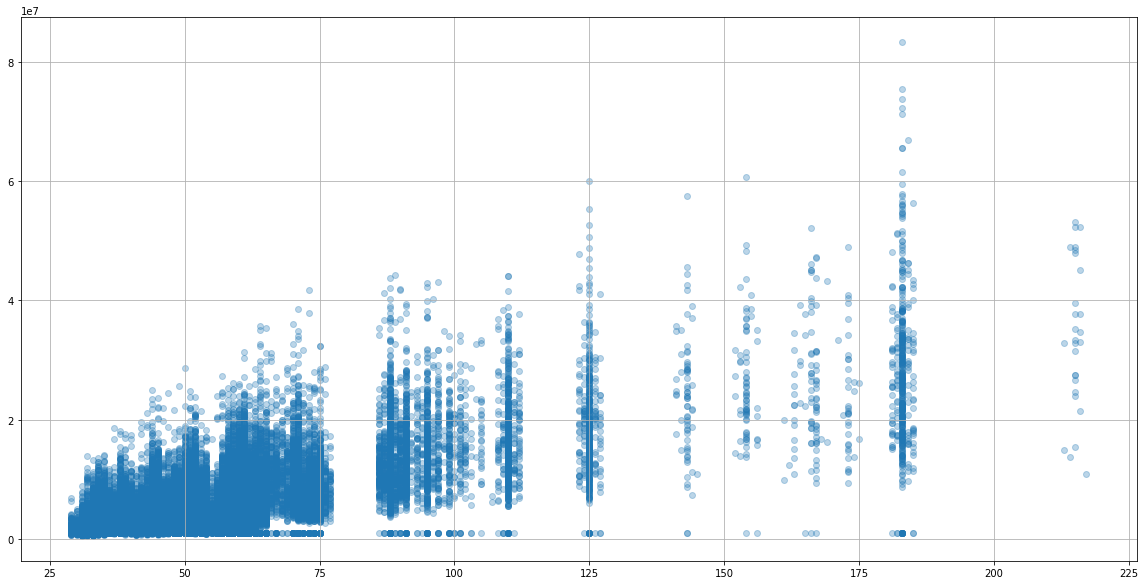

In [78]:
plt.figure(figsize=(20, 10))
plt.grid()
plt.scatter(main_train_df['area'].values, main_train_df['price'].values, alpha=0.3)
plt.show()

Judging by the dependence, there is some kind of __fixed house price for all areas__, which is strange in theory.  
In real life, the cost of a house should increase with the area of housing.  
Let's try to find the most frequently identical price

In [149]:
main_train_df['price'].value_counts()

1000000     4007
2489000       34
2948000       33
2970000       33
3091000       30
            ... 
26348000       1
12496000       1
12424000       1
12211000       1
23925000       1
Name: price, Length: 15316, dtype: int64

As we can see houses with prices 1 000 000 is the most frequenlty, so it should be deleted from our dataset

In [150]:
main_train_df = main_train_df.iloc[main_train_df['price'].values != 1000000, :]
main_train_df.shape

(95993, 13)

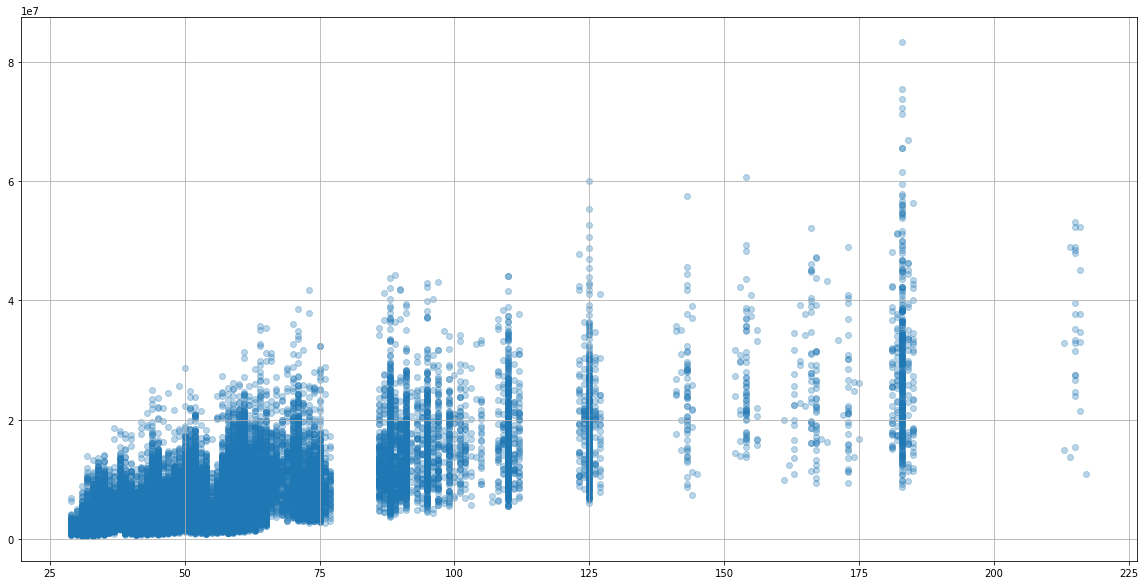

In [151]:
plt.figure(figsize=(20, 10))
plt.grid()
plt.scatter(main_train_df['area'].values, main_train_df['price'].values, alpha=0.3)
plt.show()

Now everything is ok, actually

Let's look at the distribution of sales in the data

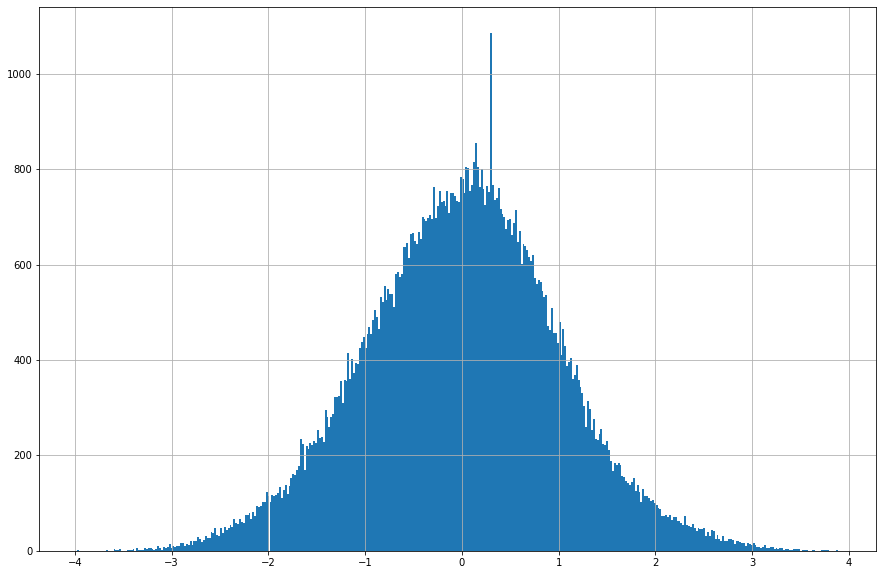

In [153]:
PT = PowerTransformer(method='box-cox', standardize=True)
PT.fit(main_train_df['price'].values.reshape(-1, 1))
test = PT.transform(main_train_df['price'].values.reshape(-1, 1))

plt.figure(figsize=(15, 10))
plt.hist(test, bins=400)
plt.grid()
plt.show()

Judging by the graph, we have a fairly large overshoot.

In [157]:
# Разбираю выброс
k = np.histogram(test, bins=400)
arg = np.argmax(k[:][0])  # номер столбика - выброса
p = k[:][0] / np.sum(k[:][0])

In [158]:
arg

217

In [161]:
# вероятности  оставлять/не оставлять элемент в выборке (прореживаю)
p = [(k[0][arg + 1] + k[0][arg - 1]) / 2 / k[0][arg], 1 - (k[0][arg + 1] + k[0][arg - 1]) / 2 / k[0][arg]]  

In [162]:
p

[0.6998158379373849, 0.3001841620626151]

In [163]:
np.random.seed(seed=42)
mask1 = np.random.choice([False, True], size = k[0][arg], p = p)  # маска элементов в выбросе
mask2 = ((test < k[1][arg + 1]) * (test > k[1][arg])).reshape(-1)  # общая масска участков

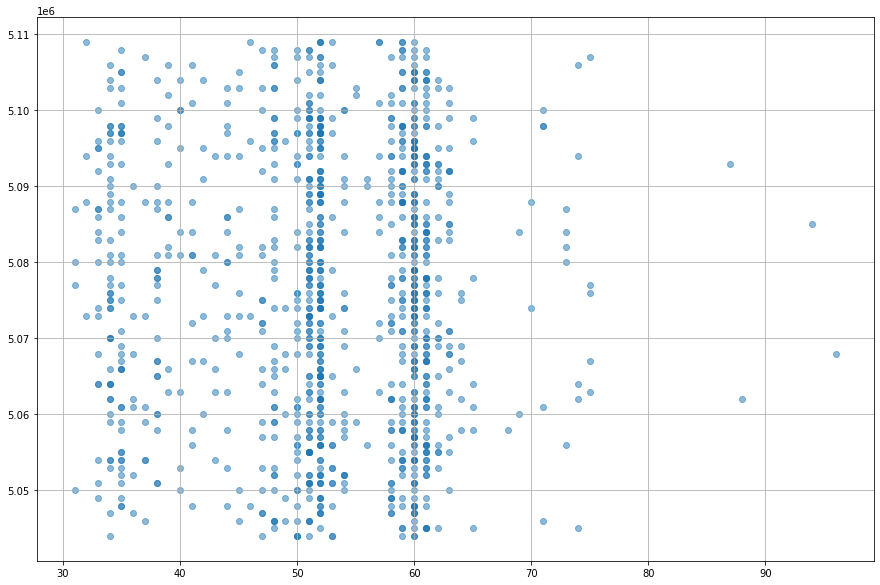

In [165]:
plt.figure(figsize=(15, 10))
plt.scatter(main_train_df['area'][mask2].values, main_train_df['price'][mask2].values, alpha = 0.5)
plt.grid()
plt.show()

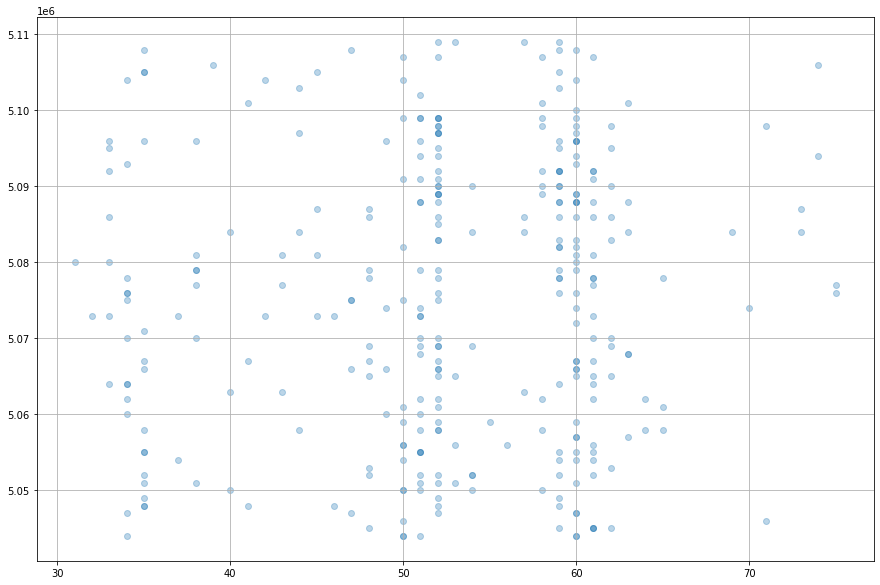

In [166]:
plt.figure(figsize=(15, 10))
plt.scatter(main_train_df['area'][mask2].values[mask1], main_train_df['price'][mask2].values[mask1], alpha = 0.3)
plt.grid()
plt.show()

In [167]:
index = main_train_df.iloc[mask2][mask1].index
main_train_df.drop(index, inplace = True)
main_train_df.shape

(95672, 13)

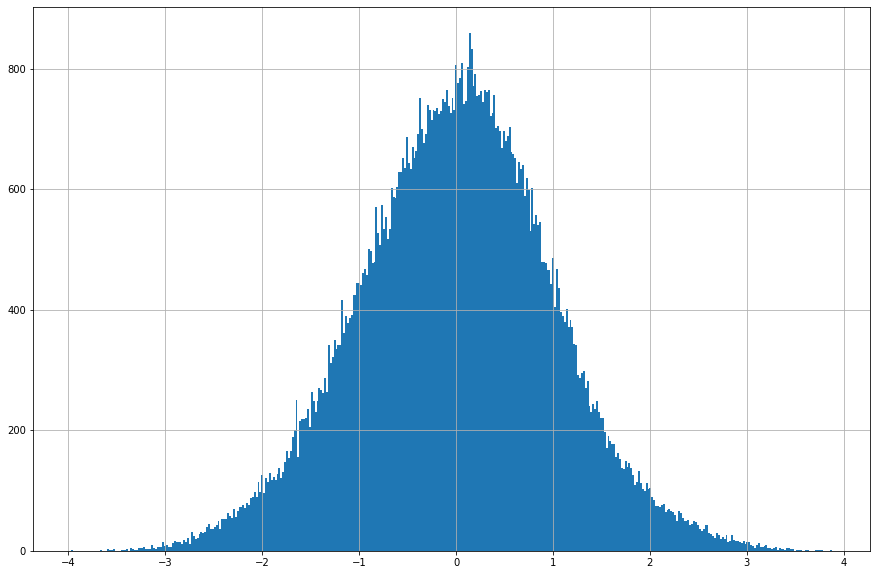

In [168]:
# вроде красивее 
PT = PowerTransformer(method='box-cox', standardize=True)
PT.fit(main_train_df['price'].values.reshape(-1, 1))
test = PT.transform(main_train_df['price'].values.reshape(-1, 1))
plt.figure(figsize=(15, 10))
plt.hist(test, bins=400)
plt.grid()
plt.show()

In [169]:
print('0 - Медиана:', np.median(main_train_df[main_train_df.build_tech.values == 0].price))
print('0 - Среднее:', np.mean(main_train_df[main_train_df.build_tech.values == 0].price))
print('1 - Медиана:', np.median(main_train_df[main_train_df.build_tech.values == 1].price))
print('1 - Среднее:', np.mean(main_train_df[main_train_df.build_tech.values == 1].price))
print('2 - Медиана:', np.median(main_train_df[main_train_df.build_tech.values == 2].price))
print('2 - Среднее:', np.mean(main_train_df[main_train_df.build_tech.values == 2].price))
main_train_df.info()

0 - Медиана: 3196000.0
0 - Среднее: 3842926.206050695
1 - Медиана: 5243000.0
1 - Среднее: 6567739.015582157
2 - Медиана: 8803500.0
2 - Среднее: 10448839.88764045
<class 'pandas.core.frame.DataFrame'>
Int64Index: 95672 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        95672 non-null  float64
 1   street_id   95672 non-null  int64  
 2   build_tech  66998 non-null  float64
 3   floor       95672 non-null  int64  
 4   area        95672 non-null  int64  
 5   rooms       95672 non-null  int64  
 6   balcon      95672 non-null  int64  
 7   metro_dist  90949 non-null  float64
 8   g_lift      66585 non-null  float64
 9   n_photos    95672 non-null  int64  
 10  kw1         95672 non-null  int64  
 11  kw2         95672 non-null  int64  
 12  price       95672 non-null  int64  
dtypes: float64(4), int64(9)
memory usage: 10.2 MB


In [170]:
df_build = main_train_df.iloc[main_train_df.build_tech.notna().values, :]
y = 'build_tech'
x = ['street_id', 'date', 'floor', 'area', 'rooms', 'balcon', 'metro_dist', 'n_photos', 'kw1', 'kw2']
x_cat = ['street_id', 'kw1', 'kw2']

In [171]:
df_train_x, df_valid_x, build_y_train, build_y_valid = train_test_split(df_build[x], df_build[y].values)
weights_train_build = df_train_x.date.values / np.sum(df_train_x.date.values)  # приоритет у более поздних квартир

In [172]:
import catboost

In [173]:
Pool_build = catboost.Pool(df_train_x, label = build_y_train, cat_features=x_cat, weight=weights_train_build)  # для обучения классификатора
Pool_test = catboost.Pool(df_valid_x, cat_features=x_cat)  # для теста качества предсказания

In [174]:
Cls = catboost.CatBoostClassifier(random_seed=42)
Cls.fit(Pool_build, verbose=False)
build_train = pred_train_build = Cls.predict(Pool_build)
build_test = pred_test_build = Cls.predict(Pool_test)

In [175]:
print(accuracy_score(build_train, build_y_train))  # 0.952
print(accuracy_score(build_test, build_y_valid))  # 0.949
print(recall_score(build_train, build_y_train, average='weighted'))  # 0.955
print(recall_score(build_test, build_y_valid, average='weighted'))  # 0.949

0.953928514567744
0.9448955223880597
0.953928514567744
0.9448955223880597


In [176]:
weights_full_build = df_build.date.values / np.sum(df_build.date.values) # приоритет у более поздних квартир
df_build_isna = main_train_df.iloc[main_train_df.build_tech.isna().values, :]

# данные для заполнения нанов
Pool_pred = catboost.Pool(df_build_isna, cat_features=x_cat)  
Pool_build_all = catboost.Pool(df_build[x], label = df_build[y], weight=weights_full_build, cat_features=x_cat)  # для обучения конечной модели

In [177]:
Cls = catboost.CatBoostClassifier()
Cls.fit(Pool_build_all, verbose = False)
test = Cls.predict(Pool_build_all)
print(recall_score(test, df_build[y], average='weighted'))  # 0.955
print(accuracy_score(test, df_build[y]))  # 0.955

0.9540284784620436
0.9540284784620436


In [93]:
pred_build = Cls.predict(Pool_pred)
main_train_df.iloc[main_train_df.build_tech.isna().values, 2] = pred_build
main_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95632 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        95632 non-null  float64
 1   street_id   95632 non-null  int64  
 2   build_tech  95632 non-null  float64
 3   floor       95632 non-null  int64  
 4   area        95632 non-null  int64  
 5   rooms       95632 non-null  int64  
 6   balcon      95632 non-null  int64  
 7   metro_dist  95632 non-null  float64
 8   g_lift      66559 non-null  float64
 9   n_photos    95632 non-null  int64  
 10  kw1         95632 non-null  int64  
 11  kw2         95632 non-null  int64  
 12  kw3         95632 non-null  int64  
 13  kw4         95632 non-null  int64  
 14  kw5         95632 non-null  int64  
 15  kw6         95632 non-null  int64  
 16  kw7         95632 non-null  int64  
 17  kw8         95632 non-null  int64  
 18  kw9         95632 non-null  int64  
 19  kw10        95632 non-nul

In [95]:
print('0 - Медиана:', np.median(main_train_df[main_train_df.g_lift.values == 0].price))
print('0 - Среднее:', np.mean(main_train_df[main_train_df.g_lift.values == 0].price))
print('1 - Медиана:', np.median(main_train_df[main_train_df.g_lift.values == 1].price))
print('1 - Среднее:', np.mean(main_train_df[main_train_df.g_lift.values == 1].price))
main_train_df.drop('g_lift', axis=1, inplace=True)  # Похоже вообще никак не связан с ценой, просто удаляю
main_train_df.head()

0 - Медиана: 4210000.0
0 - Среднее: 5365359.974789159
1 - Медиана: 4212000.0
1 - Среднее: 5323833.513838748


,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,n_photos,kw1,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
0,100.0,30,0.0,10,48,2,0,30.0,4,0,...,0,0,0,0,0,0,0,0,0,4252000
1,100.0,376,1.0,2,53,2,0,30.0,0,0,...,0,0,0,0,0,0,0,0,0,4463000
2,100.0,549,1.0,8,61,3,1,30.0,1,0,...,0,0,0,0,0,0,0,0,0,4518000
3,100.0,321,1.0,10,47,1,1,30.0,6,0,...,0,0,0,0,0,0,0,0,0,6785000
4,100.0,636,0.0,3,58,3,0,25.0,2,0,...,0,0,0,0,0,0,0,0,0,1677000


In [99]:
cat_index = ['street_id', 'kw1', 'kw2', 'Class']
df_train, df_valid, y_train, y_valid = train_test_split(main_train_df.iloc[:, :12], main_train_df.price, random_state = 42, shuffle = False)
df_valid.head()

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,n_photos,kw1,kw2,kw3
75021,739.0,658,0.0,2,41,2,0,30.0,5,0,1,0
75023,739.0,559,0.0,2,54,3,0,30.0,2,0,1,0
75024,739.0,652,1.0,5,46,1,1,25.0,0,0,1,0
75025,739.0,144,2.0,18,87,3,2,15.0,2,0,1,0
75026,739.0,559,0.0,4,60,3,0,30.0,4,1,1,0


In [101]:
weights = df_train.date.values / np.sum(df_train.date.values) # веса для наблюдений, тк предсказываем в будущее они возрастают со временем
D_train = catboost.Pool(df_train, y_train, cat_features=cat_index, weight=weights)
D_valid = catboost.Pool(df_valid, y_valid, cat_features=cat_index)

full_weights = main_train_df.date.values / np.sum(main_train_df.date.values)
X_train = catboost.Pool(main_train_df.iloc[:, :12], main_train_df.price, cat_features=cat_index, weight=full_weights)

ValueError: 'Class' is not in list

In [102]:
models = []
n_models = 5
for i in tqdm_notebook(range(n_models)):
    model = catboost.CatBoostRegressor(loss_function='MAE',
                                       learning_rate = 0.15,
                                       max_depth = 6,
                                       n_estimators = 1200,
                                       l2_leaf_reg = 50,
                                       random_state = i,
                                    #    bootstrap_type= 'Bernoulli', subsample=0.6,
                                       bootstrap_type= 'Bayesian',  bagging_temperature = 0.5,
                                       rsm = 0.7
                                       )
    model.fit(D_train,  verbose = False)
    models.append(model)

  0%|          | 0/5 [00:00<?, ?it/s]

NameError: name 'D_train' is not defined

In [103]:
model_avg = catboost.sum_models(models=models, weights=[1.0 / len(models)] * len(models))

ZeroDivisionError: float division by zero

In [104]:
pred_train = model_avg.predict(D_train)
pred_test = model_avg.predict(D_valid)

NameError: name 'model_avg' is not defined

In [105]:
print(mean_absolute_error(pred_train, y_train))  #  364 - 13
print(mean_absolute_error(pred_test, y_valid))  #   458

NameError: name 'pred_train' is not defined

In [106]:
models_full = []
for i in tqdm_notebook(range(n_models)):
    model = catboost.CatBoostRegressor(loss_function='MAE',
                                       learning_rate = 0.15,
                                       max_depth = 6,
                                       n_estimators = 1200,
                                       l2_leaf_reg = 50,
                                       random_state = i,
                                    #    bootstrap_type= 'Bernoulli', subsample=0.6,
                                       bootstrap_type= 'Bayesian',  bagging_temperature = 0.5,
                                       rsm = 0.7
                                       )
    model.fit(X_train,  verbose = False)
    models_full.append(model)

  0%|          | 0/5 [00:00<?, ?it/s]

NameError: name 'X_train' is not defined

In [107]:
model_avg_full = catboost.sum_models(models=models_full, weights=[1.0 / len(models_full)] * len(models_full))

ZeroDivisionError: float division by zero

In [108]:
df_pred = pd.read_csv('Test.csv')
df_pred.drop('id', axis=1, inplace=True)  # удалил неинформативный столбец
df_pred.metro_dist.fillna(df_pred.metro_dist.median(), inplace=True) # заполнил пропуски медианой
df_pred.drop(df_pred.columns[12:23], axis=1, inplace=True)  # остальные очень разреженные
df_pred.drop('g_lift', axis=1, inplace=True)  # Похоже вообще никак не связан с ценой, просто удаляю
df_pred.head()

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,n_photos,kw1,kw2
0,2012-3,134,NaN,2,35,1,0,30.0,1,1,1
1,2012-3,630,NaN,5,33,1,0,30.0,1,0,0
2,2012-3,437,1.0,1,60,3,1,25.0,5,0,1
3,2012-3,30,1.0,7,71,2,1,25.0,3,0,0
4,2012-3,358,1.0,4,52,2,1,30.0,0,0,1


In [109]:
# отформатировал дату
df_pred.date = pd.to_datetime(df_pred.date)
df_pred.date = df_pred.date - start
df_pred.date = df_pred.date.convert_dtypes(float) / 24 / 60 / 60 / 10 ** 9  + 100# дни
df_pred.head()

TypeError: cannot perform __truediv__ with this index type: DatetimeArray

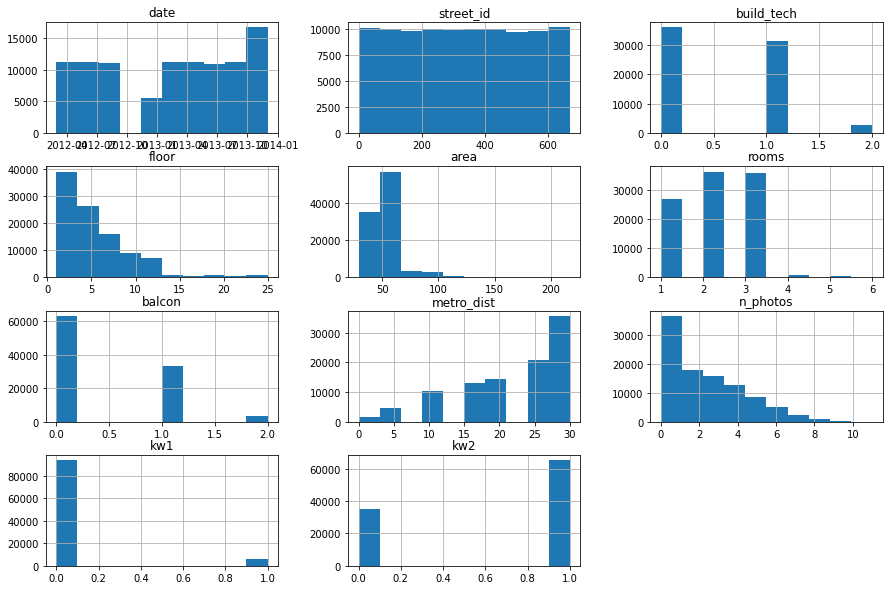

In [111]:
df_pred.hist(figsize=(15, 10))
plt.show()

In [112]:
df_build = df_pred.iloc[df_pred.build_tech.notna().values, :]
y = 'build_tech'
x = {'street_id', 'date', 'floor', 'area', 'rooms', 'balcon', 'metro_dist', 'n_photos', 'kw1', 'kw2'}
x_cat = {'street_id', 'kw1', 'kw2'}
df_train_x, df_valid_x, build_y_train, build_y_valid = train_test_split(df_build[x], df_build[y].values)
Pool_build = catboost.Pool(df_train_x, label = build_y_train, cat_features=x_cat)  # для обучения классификатора
Pool_test = catboost.Pool(df_valid_x, cat_features=x_cat)  # для теста качества предсказания

CatBoostError: feature names should be a sequence, but got {'kw1', 'kw2', 'street_id'}

In [113]:
Cls = catboost.CatBoostClassifier()
Cls.fit(Pool_build, verbose=False)
build_train = pred_train_build = Cls.predict(Pool_build)
build_test = pred_test_build = Cls.predict(Pool_test)

In [114]:
print(accuracy_score(build_train, build_y_train))  # 0.955
print(accuracy_score(build_test, build_y_valid))  # 0.942
print(recall_score(build_train, build_y_train, average='weighted'))  # 0.955
print(recall_score(build_test, build_y_valid, average='weighted'))  # 0.942

ValueError: Found input variables with inconsistent numbers of samples: [50229, 52524]

In [ ]:
df_build_isna = df_pred.iloc[df_pred.build_tech.isna().values, :]

# данные для заполнения нанов
Pool_pred = catboost.Pool(df_build_isna, cat_features=x_cat)  
Pool_build_all = catboost.Pool(df_build[x], label = df_build[y], cat_features=x_cat)  

In [ ]:
Cls = catboost.CatBoostClassifier()
Cls.fit(Pool_build_all, verbose = False)
test = Cls.predict(Pool_build_all)
print(recall_score(test, df_build[y], average='weighted'))  
print(accuracy_score(test, df_build[y]))  

In [ ]:
pred_build = Cls.predict(Pool_pred)
df_pred.iloc[df_pred.build_tech.isna().values, 2]= pred_build
df_pred.info()

In [ ]:
labels_pred = classtering.predict(df_pred[claster])
df_pred.insert(11, value=labels_pred, column='Class')  # добавил в дф столбец с метками кластера
np.unique(labels_pred, return_counts = True)

In [ ]:
X_pred = catboost.Pool(df_pred, cat_features=cat_index)

In [ ]:
Pred = model_avg_full.predict(X_pred)

In [115]:
submission = pd.read_csv('SampleSubmission.csv')
submission.price = Pred 
submission.to_csv('boost_ensemble.csv', index=False)

NameError: name 'Pred' is not defined